In [12]:
import torch
import torchvision
import os
from torch import nn
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torch.nn import Unfold

## 1. Turn single image into Patches


(-0.5, 511.5, 511.5, -0.5)

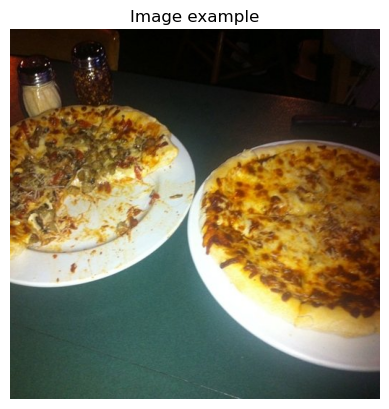

In [3]:
image_path = "../data/pizza_steak_sushi"
train_dir = os.path.join(image_path, "train")
test_dir = os.path.join(image_path, "test")
# read image as PyTorch tensor
image_np = plt.imread(os.path.join(train_dir, "pizza", "1008844.jpg"))
# Convert the NumPy array to a PyTorch tensor
image = torch.tensor(image_np).permute(2, 0, 1)  # Rearrange the dimensions
image = image / 255.0
plt.imshow(image.permute(1, 2, 0))
plt.title("Image example")
plt.axis(False)

In [4]:
# Create example values
height = 224  # H ("The training resolution is 224.")
width = 224  # W
color_channels = 3  # C
patch_size = 16  # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(
    f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}"
)

# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(
    f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}"
)

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196
Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


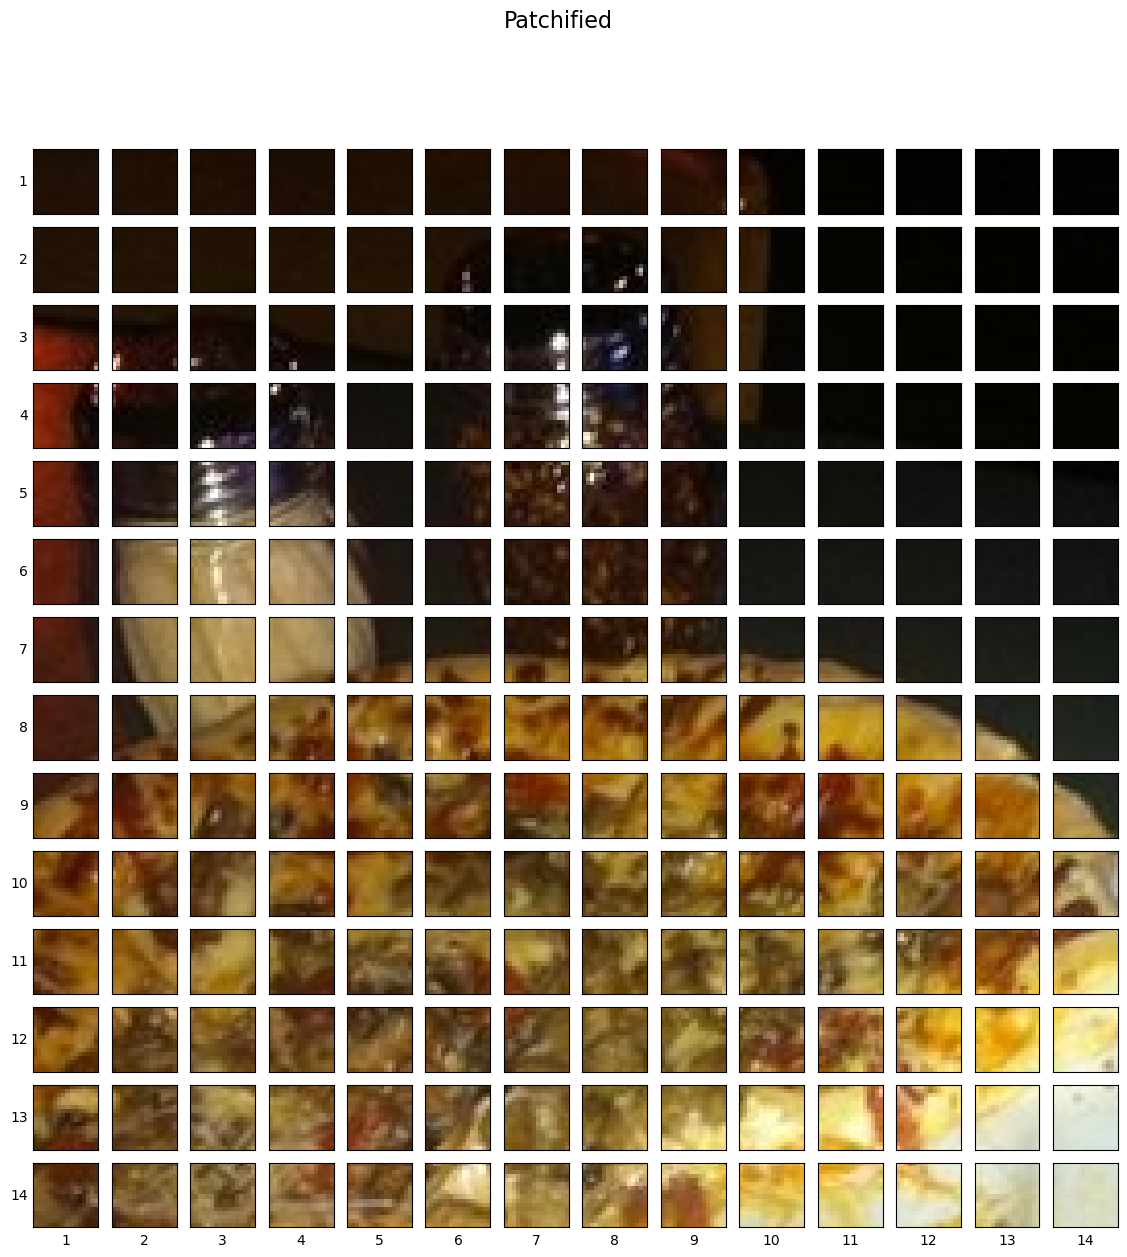

In [7]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Iterate through number of patches in the top row
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(
    f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels"
)

# Create a series of subplots
fig, axs = plt.subplots(
    nrows=img_size // patch_size,  # need int not float
    ncols=img_size // patch_size,
    figsize=(num_patches, num_patches),
    sharex=True,
    sharey=True,
)

# Loop through height and width of image
for i, patch_height in enumerate(
    range(0, img_size, patch_size)
):  # iterate through height
    for j, patch_width in enumerate(
        range(0, img_size, patch_size)
    ):  # iterate through width
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(
            image_permuted[
                patch_height : patch_height + patch_size,  # iterate through height
                patch_width : patch_width + patch_size,  # iterate through width
                :,
            ]
        )  # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(
            i + 1,
            rotation="horizontal",
            horizontalalignment="right",
            verticalalignment="center",
        )
        axs[i, j].set_xlabel(j + 1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"Patchified", fontsize=16)
plt.tight_layout()
plt.show()

# Equation 1 : Create Patch embeddings

Create class token embedding & position embedding


In [6]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """

    # 2. Initialize the class with appropriate variables
    def __init__(
        self, in_channels: int = 3, patch_size: int = 16, embedding_dim: int = 768
    ):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0,
        )

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(
            start_dim=2,  # only flatten the feature map dimensions into a single vector
            end_dim=3,
        )

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert (
            image_resolution % patch_size == 0
        ), f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(
            0, 2, 1
        )  # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [13]:
# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)

# Load and prepare the image
image = torch.randn(1, 3, 512, 512)  # Simulating a batch with a single image

# Pass the image through the patch embedding layer
patch_embedded_image = patchify(image)  # Add batch dimension

# Print the shape of the input image and the output patch embedding
print(f"Input image shape: {image.shape}")
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

# Create the class token as a learnable parameter
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
class_token = nn.Parameter(
    torch.zeros(batch_size, 1, embedding_dimension), requires_grad=True
)

# Print the shape of the class token
print(
    f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]"
)

# Concatenate the class token with the patch embeddings
patch_embedded_image_with_class_token = torch.cat(
    (class_token, patch_embedded_image), dim=1
)

# Print the shape of the concatenated embeddings
print(
    f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_token.shape} -> [batch_size, number_of_patches + 1, embedding_dimension]"
)

# Calculate the correct number of patches and create the position embeddings
number_of_patches = (512 // 16) * (
    512 // 16
)  # This should be 1024 for a 512x512 image with 16x16 patches
position_embedding = nn.Parameter(
    torch.zeros(1, number_of_patches + 1, embedding_dimension), requires_grad=True
)

# Print the shape of the position embeddings
print(
    f"Position embedding shape: {position_embedding.shape} -> [1, number_of_patches + 1, embedding_dimension]"
)

# Add the position embeddings to the patch embeddings with class token
patch_and_position_embedding = (
    patch_embedded_image_with_class_token + position_embedding
)

# Print the final shape of the embeddings after adding position embeddings
print(
    f"Patch embeddings with class token and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches + 1, embedding_dimension]"
)

Input image shape: torch.Size([1, 3, 512, 512])
Output patch embedding shape: torch.Size([1, 1024, 768])
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 1025, 768]) -> [batch_size, number_of_patches + 1, embedding_dimension]
Position embedding shape: torch.Size([1, 1025, 768]) -> [1, number_of_patches + 1, embedding_dimension]
Patch embeddings with class token and positional embeddings added shape: torch.Size([1, 1025, 768]) -> [batch_size, number_of_patches + 1, embedding_dimension]


# Equation 2 : Multi-head attention

Multi-Head Self Attention (MSA) - torch.nn.MultiheadAttention().  
Norm (LN or LayerNorm) - torch.nn.LayerNorm().


In [17]:
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short)."""

    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(
        self,
        embedding_dim: int = 768,  # Hidden size D from Table 1 for ViT-Base
        num_heads: int = 12,  # Heads from Table 1 for ViT-Base
        attn_dropout: float = 0,
    ):  # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True,
        )  # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(
            query=x,  # query embeddings
            key=x,  # key embeddings
            value=x,  # value embeddings
            need_weights=False,
        )  # do we need the weights or just the layer outputs?
        return attn_output

In [18]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(
    embedding_dim=768, num_heads=12  # from Table 1
)  # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(
    patch_and_position_embedding
)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 1025, 768])
Output shape MSA block: torch.Size([1, 1025, 768])


# Equation 3: Multilayer Perceptron (MLP)


In [20]:
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""

    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(
        self,
        embedding_dim: int = 768,  # Hidden Size D from Table 1 for ViT-Base
        mlp_size: int = 3072,  # MLP size from Table 1 for ViT-Base
        dropout: float = 0.1,
    ):  # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),  # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(
                in_features=mlp_size,  # needs to take same in_features as out_features of layer above
                out_features=embedding_dim,
            ),  # take back to embedding_dim
            nn.Dropout(
                p=dropout
            ),  # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [21]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(
    embedding_dim=768, mlp_size=3072, dropout=0.1  # from Table 1  # from Table 1
)  # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 1025, 768])
Output shape MLP block: torch.Size([1, 1025, 768])
